In [54]:
import pandas as pd
import sqlite3

## Подключение к БД

In [55]:
data = sqlite3.connect("../data/checking-logs.sqlite")

## Берем данные с таблиц

- `checker`

In [56]:
sql_request = """
SELECT uid, timestamp FROM checker
WHERE uid LIKE 'user_%'
"""

dataframe_checker = pd.read_sql(sql_request, data, parse_dates="timestamp")


In [57]:
dataframe_checker

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


## Нужно разделить даты

In [58]:
dataframe_checker["hour"] = dataframe_checker["timestamp"].dt.hour

dataframe_checker["day"] = dataframe_checker["timestamp"].dt.dayofweek

dataframe_checker["day_number"] = dataframe_checker["timestamp"].dt.day

## Пихаем сортированные дни в `day_group`

In [59]:
dataframe_checker["day_group"] = dataframe_checker["day"].apply(lambda x: "working_day" if x < 5 else "weekend")

dataframe_checker.sort_values(["day", "day_number", "hour"], inplace=True)

In [60]:
dataframe_checker

,uid,timestamp,hour,day,day_number,day_group
1190,user_30,2020-05-04 08:11:43.342744,8,0,4,working_day
1191,user_30,2020-05-04 08:12:17.805617,8,0,4,working_day
1192,user_14,2020-05-04 08:31:33.043296,8,0,4,working_day
1193,user_14,2020-05-04 08:31:38.500068,8,0,4,working_day
1194,user_31,2020-05-04 09:15:57.032274,9,0,4,working_day
...,...,...,...,...,...,...
622,user_13,2020-04-26 22:21:04.093297,22,6,26,weekend
623,user_13,2020-04-26 22:22:59.421699,22,6,26,weekend
624,user_13,2020-04-26 22:22:59.663100,22,6,26,weekend
625,user_13,2020-04-26 23:02:08.398668,23,6,26,weekend


## Групируем полученный ДФ по `"day_group"`, `"day_number"`, `"hour"`

In [61]:
group_dataframe = dataframe_checker.groupby(["day_group", "day_number", "hour"]).count().reset_index()

## Оставляем только `"day_group"`, `"day_number"`, `"hour"`, `"uid"`

In [62]:
group_dataframe = group_dataframe[["day_group", "day_number", "hour", "uid"]]

In [63]:
group_dataframe

,day_group,day_number,hour,uid
0,weekend,2,7,3
1,weekend,2,8,1
2,weekend,2,9,2
3,weekend,2,10,1
4,weekend,2,11,84
...,...,...,...,...
277,working_day,30,10,8
278,working_day,30,11,1
279,working_day,30,15,4
280,working_day,30,18,11


## Убираем дубликаты

In [64]:
unique_dataframe = group_dataframe.groupby(["day_group", "hour"]).mean("uid")

## Меняем название `uid` на `commits`

In [65]:
unique_dataframe = unique_dataframe["uid"].rename("commits")

## Удаляем индекс

In [66]:
res = unique_dataframe.reset_index()

In [67]:
res

,day_group,hour,commits
0,weekend,0,2.000000
1,weekend,1,6.000000
2,weekend,3,1.000000
3,weekend,5,2.000000
4,weekend,7,4.000000
5,weekend,8,7.000000
6,weekend,9,3.666667
7,weekend,10,7.000000
8,weekend,11,23.600000
9,weekend,12,9.500000


In [68]:
pivot = pd.pivot(res, index="hour", columns="day_group", values="commits")

In [69]:
pivot

day_group,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,NaN
3,1.000000,2.000000
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


array([<Axes: title={'center': 'weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'working_day'}, xlabel='hour'>],
      dtype=object)

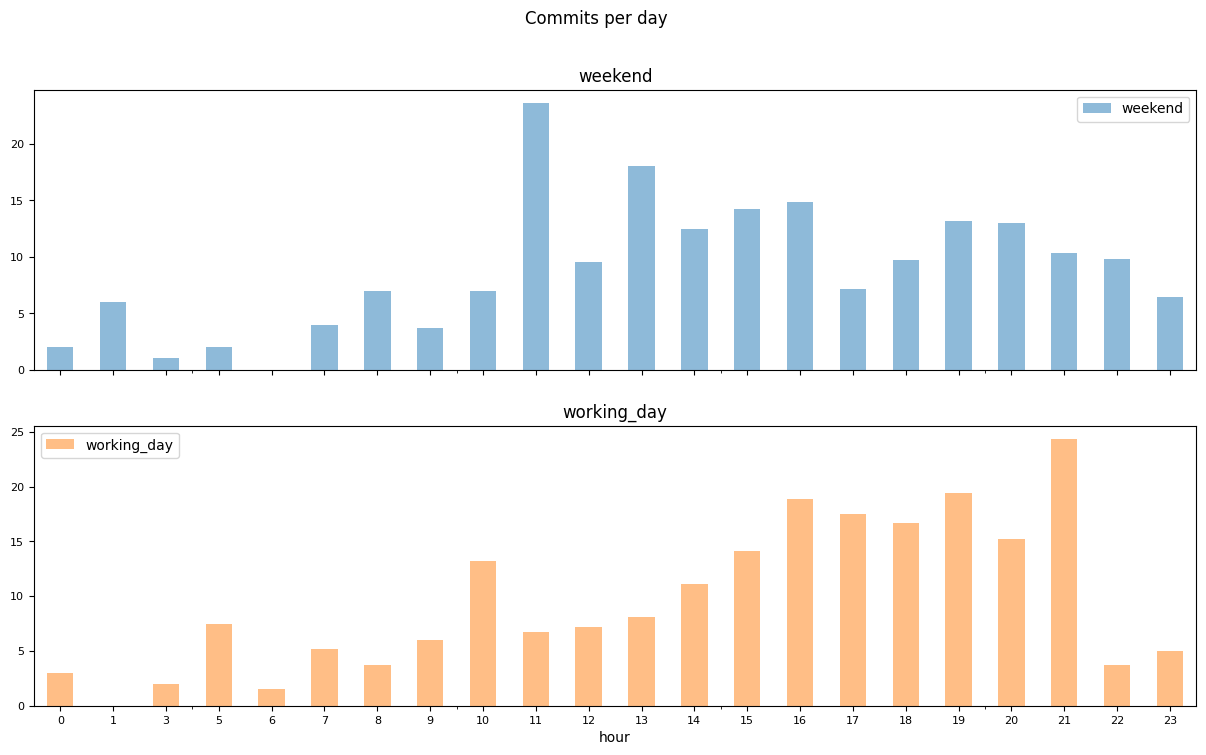

In [70]:
pivot.plot(kind="bar", subplots=True, figsize=(15, 8), fontsize=8, rot=0, title="Commits per day", alpha=0.5)

## Отличается ли динамика в рабочие дни и в выходные?

In [71]:
pivot[pivot["working_day"] == pivot["working_day"].max()]

day_group,weekend,working_day
hour,,
21,10.285714,24.333333


In [72]:
pivot[pivot["weekend"] == pivot["weekend"].max()]

day_group,weekend,working_day
hour,,
11,23.6,6.769231


In [73]:
data.close()